# Training a Classifier Using Gradients

By completing this notebook, you should get a good sense of how to use a gradient-based method to train a classifier. We're going to build modules for linear transformations of data, componentwise applications of the "sigmoid" function to a vector, and the mean-squared error loss. Once we have these modules, we will combine them to create a logistic regression classifier, which we will train on some randomly-generated data to see how the training process alters the decision-making process that the classifier goes through.

In [42]:
%pylab inline
import numpy as np
from sklearn import datasets

Populating the interactive namespace from numpy and matplotlib


## Modules

The `linear` module computes the transformation $f(x,W,b) = Wx + b$ for a given input $x$ and parameters $W$ and $b$. The main goal of "training" our classifier will be to move from the randomly initialized $W$ and $b$ that we get by instantiating a module to the "best" $W$ and $b$ for a given data set.

The `__init__` method should take an input dimension `n_in` and an output dimension `n_out`, and should create the following instance variables:

1. The `n_out` by `n_in` matrix $W$.
2. The `n_out` vector $b$.
3. The `n_out` vector `output`, representing the output of the module.
4. The `n_in` vector `gradInput`, representing $\frac{\partial L}{\partial x}$.
5. The `n_out` by `n_in` matrix `gradW`, representing $\frac{\partial L}{\partial W}$.
6. The `n_out` vector `gradb`, representing $\frac{\partial L}{\partial b}$.

The matrix $W$ and vector $b$ should be initialized randomly. The other objects can be initialized to arrays of the correct shape filled with zeros.

The `updateOutput` function should update the value of the `output` variable and should return that `output` value.

The `updateGradInput` function should update the `gradInput` variable and return the new value of `gradInput`.

The `updateGradWeight` function should update _both_ `gradW` and `gradb` and should return a tuple consisting of `gradW` and `gradb`.

In case you're rusty on your chain rule, recall that 

$$\frac{\partial L}{\partial x} = W^T \frac{\partial L}{\partial y}$$

and

$$\frac{\partial L}{\partial W} = \frac{\partial L}{\partial y} x^T$$

and

$$\frac{\partial L}{\partial b} = \frac{\partial L}{\partial y}$$.

In [43]:
class Linear(object):
    def __init__(self, n_in, n_out):
        self.W = np.random.randn(n_out, n_in)
        self.b = np.random.randn(n_out)
        
        self.output = np.zeros(n_out)
        
        self.gradInput = np.zeros(n_in)
        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)
        
    def updateOutput(self, input):
        self.output = np.dot(self.W, input) + self.b
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.dot(self.W.T, gradOutput)
        return self.gradInput
    
    def updateGradWeight(self, input, gradOutput):
        self.gradW = np.outer(gradOutput, input)
        self.gradb = gradOutput
        return (self.gradW, self.gradb)

The `Sigmoid` module will be responsible for calculating $\sigma(x) = \frac{1}{1 + \exp(-x)}$. Since there are no tunable parameters to this module, we only have to implement `updateOutput` and `updateGradInput` here.

The `__init__` function takes an integer size parameter (the number of dimensions of the input) and should create two member variables:

1. An `output` variable which represents the output of the module.
2. A `gradInput` variable which represents $\frac{\partial L}{\partial x}$.

The `updateOutput` function should compute the output of the module, store that in the `output` member variable, and return that value.

The `updateGradInput` function should update the `gradInput` member variable and return that value.  

Remember that we have the following identity:

$$ \frac{\partial L}{\partial x} = \frac{\partial L}{\partial y} * \sigma(x) * (1 - \sigma(x))$$

In [44]:
class Sigmoid(object):
    def __init__(self, n_in):
        self.output = np.zeros(n_in)
        self.gradInput = np.zeros(n_in)
    
    def updateOutput(self, input):
        self.output = 1.0 / (1.0 + np.exp(-input))
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = gradOutput * self.output * (1 - self.output)
        return self.gradInput

To estimate our performance and perform training, we will use a loss function based on the "mean squared error". For a model output $y$ and known correct answer $t$ (both vectors in some finite-dimensional vector space $\mathbb{R}^n$), this loss can be can be computed as

$$ L(y,t) = \frac{1}{n} \sum_{i=1}^n (y_i - t_i)^2 $$

Your module's `__init__` function should create the following values:

1. An `output` variable, initialized to some reasonable scalar value (like 0.0).
2. A `gradOutput` variable, which should be an `ndarray` of size $n$ (the number of dimensions of the input vector).

The `updateOutput` function should accept two arguments: `input` is the value produced by your model, and `target` is the known correct value corresponding to the model's input. The `updateOutput` argument should produce the error obtained for `input` and `target`. This will be a scalar value.

The `updateGradInput` function should calculate $\frac{\partial L}{\partial y}$ using the following relation:

$$ \frac{\partial L}{\partial y} = \frac{2}{n} * (y - t) $$

In [45]:
class MSELoss(object):
    def __init__(self, n_in):
        self.output = 0.0
        self.gradInput = np.zeros(n_in)
        
    def updateOutput(self, input, target):
        diff = input - target
        self.output = np.dot(diff, diff) / diff.shape[0]
        return self.output
    
    def updateGradInput(self, input, target):
        self.gradInput = (2.0 / input.shape[0]) * (input - target)
        return self.gradInput

The purpose of the `Classifier` object is to create an object that links together the modules defined above for the purposes of classification and training.

The `__init__` function should take an integer `n_in` giving the number of dimensions of an input point. The `__init__` function should create member variables for a `Linear` module, a `Sigmoid` module, and a `MSELoss` module, all with the approriate dimensions.

The `forward` function should accept an input that is to be classified, and optionally a `target` argument. If there is no target, the `forward` function should just return the result of the classifier's `Sigmoid` module. If there is a `target` argument, the `forward` function should call the `updateOutput` function of the classifier's `MSELoss` before returning the output of the `Sigmoid` module.

The `backward` function should take an `input`, the corresponding `target`, and should propagate derivatives backwards through the model to obtain $\frac{\partial L}{\partial W}$ and $\frac{\partial L}{\partial b}$. The `backward` function should return a tuple whose components are those derivatives.

The `predict` function should take an `input` argument and should produce a label for that point. The resulting label should be either 0 or 1.

In [46]:
class Classifier(object):
    def __init__(self, n_in):
        self.linear = Linear(n_in, 1000)
        self.sigmoid = Sigmoid(1000)
        self.linear2 = Linear(1000,1)
        self.sigmoid2 = Sigmoid(1)
        self.loss = MSELoss(1)
        
    def forward(self, input, target = None):
        out1 = self.linear.updateOutput(input)
        out2 = self.sigmoid.updateOutput(out1)
        out3 = self.linear2.updateOutput(out2)
        out4 = self.sigmoid2.updateOutput(out3)
        if target != None:
            self.loss.updateOutput(out4, target)
        return out4
    
    def backward(self, input, target):
        # Assumes forward has already been called with input
        back1 = self.loss.updateGradInput(self.sigmoid2.output, target)
        
        back2 = self.sigmoid2.updateGradInput(self.linear2.output, back1)
        back3 = self.linear2.updateGradInput(self.sigmoid.output, back2)
        grads2 = self.linear2.updateGradWeight(self.sigmoid.output, back2)
        
        back4 = self.sigmoid.updateGradInput(self.linear.output, back3)
        back5 = self.linear.updateGradInput(input, back4)
        grads = self.linear.updateGradWeight(input, back4)
        return grads, grads2
    
    def predict(self, input):
        out = self.forward(input)
        if out <= 0.5:
            return 0
        else:
            return 1

To see if our system learns anything, we're going to do a 2D classification problem (just like kNN). The next cell generates and visualizes the data. 

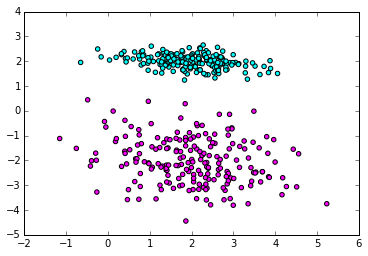

In [47]:
(easy_x, easy_y) = datasets.make_classification(n_samples=400, n_features = 2, n_informative = 2,
                             n_redundant = 0, n_repeated = 0, n_clusters_per_class=1, class_sep=2)
scatter(easy_x[:,0], easy_x[:,1], c = easy_y, cmap = 'cool')

Since we're doing a classification problem in the plane, the next line should produce exactly what we need.

In [48]:
classifier = Classifier(2)

The next cell shows what an untrained classifier does. Unless you happen to get lucky, you should see no correlation between the line drawn by your classifier and the distribution of points.

We also print out the $W$ and $b$ parameters for our model. These will be modified by training.

[[-0.04641675 -1.51234176]
 [-0.82536906 -0.57582886]
 [-0.32604212  1.44387514]
 ..., 
 [-1.95991527 -2.37912757]
 [ 0.78959454 -2.55728138]
 [-0.12662831 -1.30606516]] [  5.29204477e-02  -1.26753055e+00  -3.08796964e-01   1.50843690e-01
   3.23143711e-01  -5.18789415e-01   7.67494398e-01   1.42979553e-01
   3.13014158e-01  -6.60699470e-01  -8.30748213e-02   8.90461542e-01
  -7.56947536e-01  -7.75175154e-01  -7.18388591e-01  -3.42427926e-01
   1.38235713e+00   1.19923579e+00   6.94765525e-01   1.01546568e+00
  -1.65116646e-01  -2.72727777e+00   1.01739058e+00   8.68637620e-01
   9.83768382e-01   6.31878364e-02  -3.81042461e-01   9.22311514e-01
   8.89302172e-01  -2.62070605e-01  -7.68369359e-01   1.23860993e+00
   9.15468903e-01   1.40792862e-01   7.67266930e-01  -7.00074200e-01
   1.67536618e-01   9.43140639e-02   1.13492644e-02   9.84638459e-04
   7.76853325e-01  -1.05749495e+00  -6.41441406e-01  -1.99688034e+00
  -1.32448369e+00  -5.17452298e-03  -3.50110570e-01  -1.21748867e-01
  

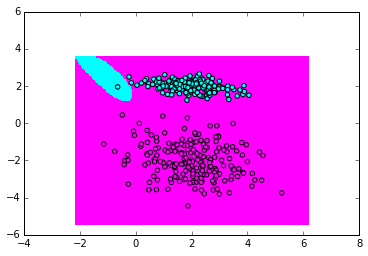

In [49]:
h = 0.05 # mesh size
x_min, x_max = easy_x[:, 0].min() - 1, easy_x[:,0].max() + 1
y_min, y_max = easy_x[:, 1].min() - 1, easy_x[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = []
for pt in np.c_[xx.ravel(), yy.ravel()]:
    Z.append(classifier.predict(pt))
Z = np.asarray(Z)
Z = Z.reshape(xx.shape)
figure()
pcolormesh(xx,yy, Z, cmap='cool')

print classifier.linear.W, classifier.linear.b

scatter(easy_x[:,0], easy_x[:,1], c=easy_y, cmap='cool')

The process of training should be the following:

- Loop over the entire dataset $k$ times (say, 1000). On each iteration:
- Loop over each point in the dataset. For a given point in the dataset (consisting of an input $x$ and a label $y$):
- Run the classifier's `forward` method to compute an error for the given $(x,y)$ pair.
- Then run the classifier's `backward` method to get the necessary gradients.
- Then update the model parameters using the gradient descent update rule described in class. On iteration $k+1$, the update rules you should use are

  $$ W^{(k+1)} \leftarrow W^{(k)} - \alpha_W * \frac{\partial L}{\partial W} $$ 
  
  and

  $$ b^{(k+1)} \leftarrow b^{(k)} - \alpha_b * \frac{\partial L}{\partial b} $$

In [50]:
# training
for i in range(100):
    for j in range(easy_x.shape[0]):
        err = classifier.forward(easy_x[j], easy_y[j])
        grads, grads2 = classifier.backward(easy_x[j], easy_y[j])
        
        
        classifier.linear.W -= 1e-3 * grads[0]
        classifier.linear2.W -= 1e-3 * grads2[0]
        classifier.linear.b -= 1e-3 * grads[1]
        classifier.linear2.b -= 1e-3 * grads2[1]

Once properly trained, the decision line determined by your model should "line up" correctly with your data, so we re-run the mesh visualization to see how we do. We will learn about quantifying our error later in the course.

[[-0.04396902 -1.50969012]
 [-0.82513888 -0.57629953]
 [-0.34294968  1.4338839 ]
 ..., 
 [-1.95992939 -2.3791455 ]
 [ 0.84387989 -2.53011775]
 [-0.12858871 -1.3075933 ]] [  4.68780882e-02  -1.25982560e+00  -3.07452121e-01   1.51009985e-01
   3.22386567e-01  -5.24015095e-01   7.68183177e-01   1.44191488e-01
   3.07056920e-01  -6.52886170e-01  -8.15479973e-02   8.79149162e-01
  -7.55602024e-01  -7.75128751e-01  -7.14118892e-01  -3.41835574e-01
   1.37552748e+00   1.20116083e+00   6.95176178e-01   1.01397242e+00
  -1.61243327e-01  -2.72799957e+00   1.01719664e+00   8.67878042e-01
   9.82606844e-01   6.26186602e-02  -3.79697977e-01   9.22350078e-01
   8.89586699e-01  -2.59256596e-01  -7.71678817e-01   1.23783855e+00
   9.13459746e-01   1.41699453e-01   7.70597166e-01  -7.00235113e-01
   1.69342865e-01   9.41191727e-02   1.48448351e-02   5.36734341e-03
   7.79419017e-01  -1.05887674e+00  -6.45941691e-01  -1.99445151e+00
  -1.32404461e+00  -8.80000780e-04  -3.54254203e-01  -1.22538187e-01
  

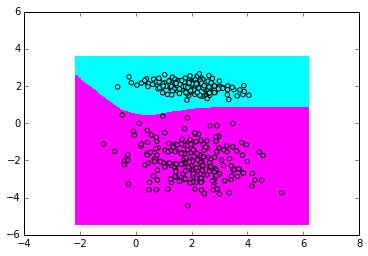

In [51]:
h = 0.05 # mesh size
x_min, x_max = easy_x[:, 0].min() - 1, easy_x[:,0].max() + 1
y_min, y_max = easy_x[:, 1].min() - 1, easy_x[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = []
for pt in np.c_[xx.ravel(), yy.ravel()]:
    Z.append(classifier.predict(pt))
Z = np.asarray(Z)
Z = Z.reshape(xx.shape)
figure()
pcolormesh(xx,yy, Z, cmap='cool')

print classifier.linear.W, classifier.linear.b

scatter(easy_x[:,0], easy_x[:,1], c=easy_y, cmap='cool')